In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble.partial_dependence import plot_partial_dependence

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 

ModuleNotFoundError: No module named 'sklearn.ensemble.partial_dependence'

Loan ID                          object
Customer ID                      object
Loan Status                      object
LoanAmount                        int64
Term                             object
Credit Score                    float64
Annual Income                   float64
Years in current job             object
Home Ownership                   object
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent    float64
Number of Open Accounts           int64
Number of Credit Problems         int64
Current Credit Balance            int64
Maximum Open Credit             float64
Bankruptcies                    float64
Tax Liens                       float64
dtype: object

Sum of null values in each feature:
-----------------------------------
Loan ID                             0
Customer ID                         0
Loan Status                         0
LoanAmount                          0
T

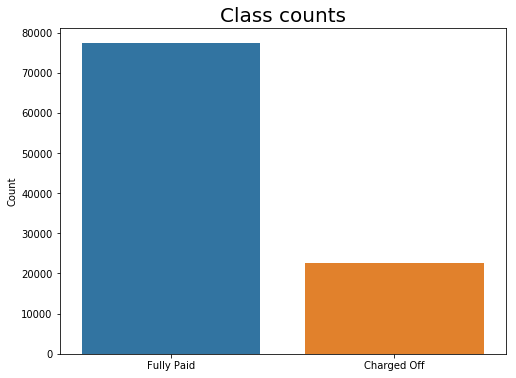

In [2]:
df = pd.read_csv("/kaggle/input/credit_train.csv")
# Check both the datatypes and if there is missing values print(f"Data types:\n{11 * '-'}")
print(f"{df.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{df.isnull().sum()}")
df.head()

# Get number of positve and negative examples
pos = df[df["Loan Status"] == "Charged Off"].shape[0]
neg = df[df["Loan Status"] == "Fully Paid"].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")


plt.figure(figsize=(8, 6))
sns.countplot(df["Loan Status"])
plt.xticks((0, 1), ["Fully Paid", "Charged Off"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});
plt.show()


In [3]:
number = LabelEncoder()
for x in df.columns:
    if df[x].dtype == 'object':
        df[x].fillna('NaN',inplace = True)
        df[x] = number.fit_transform(df[x])
X = df.loc[:, df.columns != "Loan Status"].values
y = df.loc[:, df.columns == "Loan Status"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.25, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((75000, 18), (25000, 18))


In [4]:


# Standardize the data
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

#Impute missing values
imp = SimpleImputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)


# Implement RandomUnderSampler
random_undersampler = RandomUnderSampler()
X_train, y_train = random_undersampler.fit_sample(X_train, y_train)

# Shuffle the data
perms = np.random.permutation(X_train.shape[0])
X_train = X_train[perms]
y_train = y_train[perms]
print(X_train.shape)

(33958, 18)


In [5]:
# Define base learners
logreg_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',n_jobs = 3)
mlp_clf = MLPClassifier(max_iter=300,activation = 'relu',
                        solver='adam',
                        random_state=1)
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123)
svm_clf = SVC(C=0.1,
              kernel="poly",
              degree=3,
              coef0=10.0,
              probability=True)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features="sqrt",
                                criterion="entropy",
                                min_samples_leaf=5,
                                class_weight="balanced")
#lda_clf = LinearDiscriminantAnalysis(solver='svd')

#knn_clf = KNeighborsClassifier(n_neighbors=3)

#mlp_clf.fit(X_train,y_train)
#print("MLPfinish")
#svm_clf.fit(X_train,y_train)
#print("svmfinish")
#rf_clf.fit(X_train,y_train)
#print("rffinish")
#print(accuracy_score(y_test,mlp_clf.predict(X_test)))
#print(accuracy_score(y_test,svm_clf.predict(X_test)))
#print(accuracy_score(y_test,rf_clf.predict(X_test)))


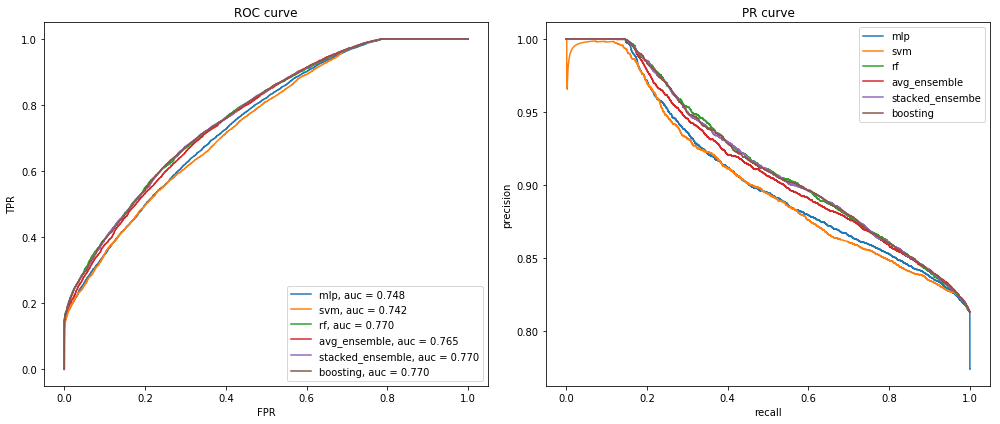

In [6]:
# Define meta-learner
logreg_clf = LogisticRegression(penalty="l2", C=100, fit_intercept=True)
# Fitting voting clf --> average ensemble
voting_clf = VotingClassifier([("mlp", mlp_clf),
                               ("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)
voting_clf.fit(X_train, y_train)
mlp_model, svm_model, rf_model = voting_clf.estimators_
models = {"mlp": mlp_model,
          "svm": svm_model,
          "rf": rf_model,
          "avg_ensemble": voting_clf}

# Build first stack of base learners
first_stack = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))

# Use CV to generate meta-features
meta_features = cross_val_predict(first_stack, X_train, y_train, cv=10, method="transform")

# Refit the first stack on the full training set
first_stack.fit(X_train, y_train)

# Fit the meta learner
second_stack = logreg_clf.fit(meta_features, y_train)
third_stack = xgb_clf.fit(meta_features,y_train)
# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
  model_probs = model.predict_proba(X_test)[:, 1:]
  model_auc_score = roc_auc_score(y_test, model_probs)
  fpr, tpr, _ = roc_curve(y_test, model_probs)
  precision, recall, _ = precision_recall_curve(y_test, model_probs)
  axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
  axes[1].plot(recall, precision, label=f"{name}")

stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")

stacked_probs = third_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"boosting, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="boosting")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()
